# Regression

Version: 2025-10-6

In this notebook, we will learn how to run a regression in Python and investigate the effect of regularization. We will be using several Python libraries: ```pandas``` for organizing data, ```statsmodel```, ```scikit-learn``` for analysis and ```numpy``` for calculating mean and standard deviations.

In [1]:
import pandas as pd #organize data
import numpy as np #calculate mean and standard deviation

### A. Loading Data

We first load the data we need. ```auto.csv``` contains the information of 74 vehicle models from 1978. We can load it with panda's ```read_csv()``` method:

In [2]:
# Load data. Specify the full path if your data 
# is not in the same directory as the notebook
auto = pd.read_csv("../Data/auto.csv")

We can fetch columns just like if we are using a dictionary:

In [3]:
# Fetch a column
auto[["price"]]

,price
0,4099
1,4749
2,3799
3,4816
4,7827
...,...
69,7140
70,5397
71,4697
72,6850


In [4]:
# See more than one columns
auto[["price","mpg"]]

,price,mpg
0,4099,22
1,4749,17
2,3799,22
3,4816,20
4,7827,15
...,...,...
69,7140,23
70,5397,41
71,4697,25
72,6850,25


By default ```pandas``` returns a lot of rows. If you just want to get an idea how the data looks lke, it might be useful just to fetch a few rows from the top or the bottom of the data:

In [5]:
print(auto[["price","mpg"]].head()) #top
print(auto[["price","mpg"]].tail()) #bottom

   price  mpg
0   4099   22
1   4749   17
2   3799   22
3   4816   20
4   7827   15
    price  mpg
69   7140   23
70   5397   41
71   4697   25
72   6850   25
73  11995   17


### B. Ordinary Least Squares Regression

Now that we have data, we can run a simple **Ordinary Least Squares** (OLS) regression. 


Let $y_i$ be the target/dependent variable and 
$x_i$ a vector of features/independent variables of observation $i$.
OLS have the following objective function:
$$
\min_{a, \beta}{\sum_{i}{[y_i-(a+x_i\beta)]}}
$$
$a$ is called the *intecept* and $\beta$ *coefficients*. These are parameters that needs to be estimated by the model.

OLS is common enough that it is included in more than one library. The choices are:
- ```statsmodels.api.OLS```: formatted output, statistics
- ```sklearn.linear_model.LinearRegression```: no output, machine learning

```Statsmodel``` gives formatted statistical output:

In [6]:
# statsmodel OLS
import statsmodels.api as sm

# statsmodel does not add the constant by default, so add manually
results = sm.OLS(auto["price"],
                 sm.add_constant(auto[["mpg","weight"]])).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.293
Model:                            OLS   Adj. R-squared:                  0.273
Method:                 Least Squares   F-statistic:                     14.74
Date:                Mon, 06 Oct 2025   Prob (F-statistic):           4.42e-06
Time:                        14:00:34   Log-Likelihood:                -682.86
No. Observations:                  74   AIC:                             1372.
Df Residuals:                      71   BIC:                             1379.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1946.0687   3597.050      0.541      0.590   -5226.245    9118.382
mpg          -49.5122     86.156     -0.575      0.567    -221.302     122.278
weight         1.7466      0.641      2.723      0.008       0.468       3.025
==============================================================================
Omnibus:                       13.514   Durbin-Watson:                   1.108
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               14.723
Skew:                           1.055   Prob(JB):                     0.000635
Kurtosis:                       3.567   Cond. No.                     3.84e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.84e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Train a model in ```scikit-learn```:

In [7]:
from sklearn.linear_model import LinearRegression

ols = LinearRegression()
ols.fit(auto[["mpg","weight"]],auto["price"])

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


What we did above is common to all ```scikit-learn``` models:
1. Specify the model we need.
2. Train the model with ```fit()```.

To get an idea how well the model does we can use the ```score()``` method.
For regressions this returns the $R^2$ statistic:

In [8]:
# R-squared
ols.score(auto[["mpg","weight"]],auto["price"])

0.29338912319475285

Fitted values can be obtained by calling ```predict()```:

In [9]:
# Predict the price of a car with mpg of 10 and weight of 2000
ols.predict([[10,2000]])

/opt/network/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


array([4944.06477799])

The warning is due to us training the model with data that comes with feature names, but now we try to provide it with a new sample that comes without. To get rid of the warning, we can always provide feature names, or never provide them.

In [10]:
# Option 1: always provide feature names by using dataframes throughout
ols.fit(auto[["mpg","weight"]],auto[["price"]])
df = pd.DataFrame([[10,2000]],columns=["mpg","weight"])
ols.predict(df)

array([[4944.06477799]])

In [11]:
# Option 2: never provide feature names by using values throughout
ols.fit(auto[["mpg","weight"]].values,auto[["price"]])
ols.predict([[10,2000]])

array([[4944.06477799]])

As a machine-learning library, ```scikit-learn``` makes it very easy to build models by hiding a lot of the details behind the background. Here is how to fetch the regression coefficients:

In [12]:
# Coefficients
print("Coefficients:",ols.coef_)
print("Intecept:",ols.intercept_)

Coefficients: [[-49.51222067   1.74655916]]
Intecept: [1946.06866796]


The problem with using OLS as a predictive model is that its predictions have very high variance, meaning that predictions vary significantly across models trained with different samples.

To see this, we will:
1. Repeatedly draw samples of data.
2. Train the model.
3. Make predictions base on the model.
4. Calculate the mean and standard deviation of predictions from different samples.

In [13]:
from sklearn.utils import resample #for resampling

# Whole data
x_pop = auto[["mpg","weight"]]
y_pop = auto["price"]

# Empty list to contain predictions
predict_list = []

# Draw random samples and fit model for 30 times
for i in range(30):
    
    # Draw 20 random samples
    y,x = resample(y_pop,x_pop,n_samples=20) 
    model = LinearRegression() #OLS
    model.fit(x.values,y)
    
    xb = model.predict([[10,2000]]) #Predict price
    predict_list.append(xb) #Append the predicted price to predict_list 

print("Mean of predictions:", np.mean(predict_list)) #mean of predictions    
print("S.D. of predictions:", np.std(predict_list)) #standard deviation of predictions


Mean of predictions: 5796.363526197115
S.D. of predictions: 5032.820387922387


### C. Regularized Regression

**Ridge Regression** have the following objective function:
$$
\min_{a, \beta}{\left\{ \sum_{i}{[y_i-(a+x_i\beta)]}+\alpha \sum_{k}{\beta_k^2} \right\} }
$$
$\alpha$ is the strength of regularization. All else equal, higher $\alpha$ would result in smaller coefficients.

Scikit-learn's ridge regression is ```Ridge()```. Play around with different values of ```alpha```&mdash;e.g. 50, 5000, 5000000&mdash;and see how the estimated coefficients change.

In [14]:
from sklearn.linear_model import Ridge

# Run a ridge regression
ridge = Ridge(alpha=5000)
ridge.fit(auto[["mpg","weight"]],auto["price"])

# Coefficients
print("Coefficients:",ridge.coef_)
print("Intecept:",ridge.intercept_)

Coefficients: [-7.21498025  2.00048319]
Intecept: 278.5384537611908


**Lasso Regression** have the following objective function:
$$
\min_{a, \beta}{\left\{ \sum_{i}{[y_i-(a+x_i\beta)]}+\alpha \sum_{k}{\left|\beta_k\right|} \right\} }
$$
$\alpha$ is the strength of regularization. All else equal, higher $\alpha$ would result more coefficients becoming zero. As before, play around with ```alpha``` to get an idea of how the coefficients change.

In [15]:
from sklearn.linear_model import Lasso 

# Run a lasso regression
lasso = Lasso(alpha=5000)
lasso.fit(auto[["mpg","weight"]],auto["price"])

# Coefficients
print("Coefficients:",lasso.coef_)
print("Intecept:",lasso.intercept_)

Coefficients: [-0.          2.03567146]
Intecept: 18.629324665401327


### D. Standardizing Data

Because regularization penalizes large coefficients, standardizing data is usually necessary, otherwise variables with small units of measure&mdash;thus large coefficients&mdash;will get unfairly penalized.

In [16]:
from sklearn.linear_model import Lasso 
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Run a lasso regression after standardizing data
scaler = StandardScaler()
lasso = Lasso(alpha=50)
lasso_pipe = Pipeline(steps=[("scaler", scaler),
                       ("lasso", lasso)])
lasso_pipe.fit(auto[["mpg","weight"]],auto["price"])

# Coefficients
print("Coefficients:",lasso_pipe["lasso"].coef_)
print("Intecept:",lasso_pipe["lasso"].intercept_)

Coefficients: [-257.04604023 1320.38067856]
Intecept: 6165.256756756757


### E. Regularized vs Non-Regularized: Coefficient Estimates

For a more systematic examination, let us pick a list of regularization strengths and use a loop to run the three types of regressions. We will store the estimated coefficients and plot them in two diagrams with the ```matplotlib``` library.

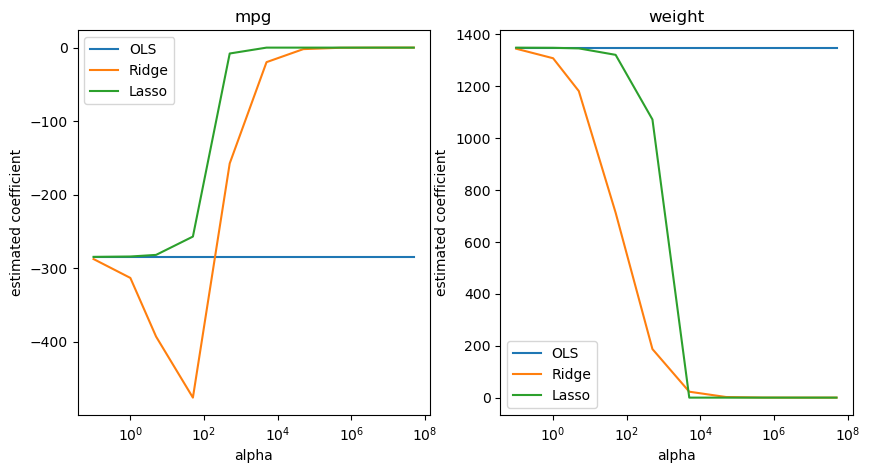

In [17]:
# Alphas to go through
alphas = [0.1,1,5,50,500,5000,50000,500000,5000000,50000000]

# Empty lists to store coefficients
mpg_ols = []
mpg_ridge = [] 
mpg_lasso = []
weight_ols = []
weight_ridge = []
weight_lasso = []

# Run regressions for each alpha and save coefficients 
for a in alphas:
    # OLS
    scaler = StandardScaler()
    ols = LinearRegression()
    ols_pipe = Pipeline(steps=[("scaler",scaler),
                               ("ols",ols)])
    ols_pipe.fit(auto[["mpg","weight"]],auto["price"])
    mpg_ols.append(ols_pipe["ols"].coef_[0]) #Append coef. of mpg to list mpg_ols
    weight_ols.append(ols_pipe["ols"].coef_[1]) #Append coef. of weight to list weight_ols
    
    # Ridge
    scaler1 = StandardScaler()
    ridge = Ridge(alpha=a)
    ridge_pipe = Pipeline(steps=[("scaler", scaler1),
                                 ("ridge", ridge)])
    ridge_pipe.fit(auto[["mpg","weight"]],auto["price"])
    mpg_ridge.append(ridge_pipe["ridge"].coef_[0])
    weight_ridge.append(ridge_pipe["ridge"].coef_[1])
    
    # Lasso
    scaler2 = StandardScaler()
    lasso = Lasso(alpha=a)
    lasso_pipe = Pipeline(steps=[("scaler", scaler2),
                                 ("lasso", lasso)])
    lasso_pipe.fit(auto[["mpg","weight"]],auto["price"])
    mpg_lasso.append(lasso_pipe["lasso"].coef_[0])
    weight_lasso.append(lasso_pipe["lasso"].coef_[1])
    
# Import library for graphing    
%matplotlib inline
import matplotlib.pyplot as plt

# Plot mpg graph
fig, (gm, gw) = plt.subplots(ncols=2,figsize=(10,5))
gm.set_title("mpg")
gm.set_ylabel("estimated coefficient")
gm.set_xlabel("alpha")
gm.set_xscale("log")
gm.plot(alphas, mpg_ols, label='OLS')
gm.plot(alphas, mpg_ridge, label='Ridge')
gm.plot(alphas, mpg_lasso, label='Lasso')
gm.legend(loc=0)

# Plot weight graph
gw.set_title("weight")
gw.set_ylabel("estimated coefficient")
gw.set_xlabel("alpha")
gw.set_xscale("log")
gw.plot(alphas, weight_ols, label='OLS')
gw.plot(alphas, weight_ridge, label='Ridge')
gw.plot(alphas, weight_lasso, label='Lasso')
gw.legend(loc=0)

### F. Regularized vs Non-Regularized: Prediction Variance

How does the regularized regressions help with the problem of variance? To investigate, we will repeat what we did previously:
1. Repeatedly draw samples of data.
2. Train various models.
3. Make predictions base on the models.
4. Calculate the mean and standard deviation of predictions from different models and different samples.

For ridge and lasso, we additionally need to try different values of alpha.

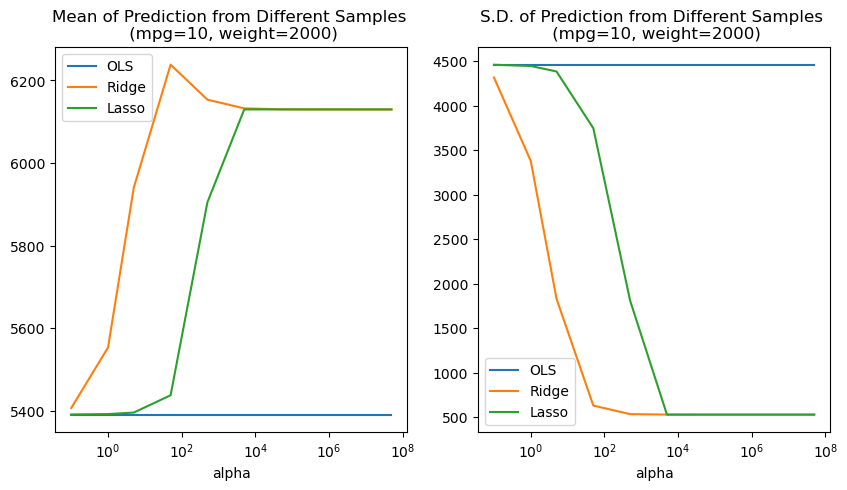

In [18]:
# Alphas to go through
alphas = [0.1,1,5,50,500,5000,50000,500000,5000000,50000000]

# An sample/observation of independent variables to be used for prediction
query = [[10,2000]]

# Empty lists to contain mean predictions
ols_mean = []
ridge_mean = []
lasso_mean = []

# Empty lists to contain standard deviations
ols_std = []
ridge_std = []
lasso_std = []

# Empty list for subsamples
subsamples = []
# Draw 20 random samples and fit models for 50 times
for i in range(50):
    subsamples.append(resample(y_pop,x_pop,n_samples=20))

# Loop through alphas
for a in alphas: 
    
    # Empty lists to contain predictions
    ols_predict = []
    ridge_predict = []
    lasso_predict = []

    for i in range(50):    
        y,x = subsamples[i]

        # OLS
        ols = LinearRegression()
        ols.fit(x.values,y)
        ols_xb = ols.predict(query) 
        ols_predict.append(ols_xb)
        
        # Ridge
        scaler1 = StandardScaler()
        ridge = Ridge(alpha=a)
        ridge_pipe = Pipeline(steps=[("scaler", scaler1),
                               ("ridge", ridge)])
        ridge_pipe.fit(x.values,y)
        ridge_xb = ridge_pipe.predict(query)
        ridge_predict.append(ridge_xb)

        # Lasso
        scaler2 = StandardScaler()
        lasso = Lasso(alpha=a)
        lasso_pipe = Pipeline(steps=[("scaler", scaler2),
                               ("lasso", lasso)])
        lasso_pipe.fit(x.values,y)
        lasso_xb = lasso_pipe.predict(query)
        lasso_predict.append(lasso_xb)         

    # Calculate and store mean prediction
    ols_mean.append(np.mean(ols_predict))
    ridge_mean.append(np.mean(ridge_predict))
    lasso_mean.append(np.mean(lasso_predict))        
        
    # alculate and store standard deviations
    ols_std.append(np.std(ols_predict))
    ridge_std.append(np.std(ridge_predict))
    lasso_std.append(np.std(lasso_predict))

# Import library for graphing    
%matplotlib inline
import matplotlib.pyplot as plt    

# Plot mean
fig, (mn, sd) = plt.subplots(ncols=2,figsize=(10,5))
mn.set_title("Mean of Prediction from Different Samples \n (mpg=10, weight=2000)")
mn.set_xlabel("alpha")
mn.set_xscale("log")
mn.plot(alphas, ols_mean, label='OLS')
mn.plot(alphas, ridge_mean, label='Ridge')
mn.plot(alphas, lasso_mean, label='Lasso')
mn.legend(loc=0)  

# Plot standard deviations
sd.set_title("S.D. of Prediction from Different Samples \n (mpg=10, weight=2000)")
sd.set_xlabel("alpha")
sd.set_xscale("log")
sd.plot(alphas, ols_std, label='OLS')
sd.plot(alphas, ridge_std, label='Ridge')
sd.plot(alphas, lasso_std, label='Lasso')
sd.legend(loc=0)  

Two things you should have noticed:
- OLS is unbiased, while Ridge and Lasso are biased.
- Ridge and lasso have much smaller variance than OLS when ```alpha``` is large.

### E. Conclusion

In this notebook, we have investigated how regularization can help reduce the variance of predictions. This ensures that the model we trained on a particular sample of data will be reasonably accurate when applied to other samples. 

A question that we have not yet touch on is, how do we choose the strength of regularization, ```alpha```? Conceptually, what we want to do is to pick a value that gives us the most accurate prediction when applied to other samples. In order to do so we would need to conduct out-of-sample test, which is the topic of the next notebook.